In [10]:
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [11]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]

Mp, zp = 10**14.3, 0.5
list_coupures = np.linspace(20, 80, 13)
print("liste des coupures :", list_coupures)

liste des coupures : [20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.]


In [55]:
# permet de récupérer des valeurs numériques pour moy et sigma à partir d'un bin
def _ln_L_1(params, X):
    moy, sigma = params
    moy, sigma = moy*np.ones(len(X)), sigma*np.ones(len(X))
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-moy)/sigma)**2)
    return -ln_L

# permet de récupérer A, B, C à partir des moyennes
def _ln_L_2(params, X, moy):
    A, B, C = params
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    f = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    return np.sum((moy - f)**2)

In [44]:
def minimize_1(X, p0):
    bounds = [
    (1, np.inf),  # moy
    (1e-3, np.inf),  # std
    ]
    res = scipy.optimize.minimize(_ln_L_1, p0, args=(X,), method='L-BFGS-B', bounds = bounds)
    if not res.success:
        return [None]
    return res.x

def minimize_2(X, moy, p0 = [None]):
    if p0[0] == None:
        p0 = np.random.uniform(1e-3, 0.2, 3)  # [A, B, C]
    bounds = [
    (0, np.inf),  # A
    (0, np.inf),  # B
    (-2, 2)       # C
    ]
    res = scipy.optimize.minimize(_ln_L_2, p0, args=(X, moy), method='L-BFGS-B', bounds = bounds)
    if not res.success:
        return [None]
    return res.x

def minimize_3(X, std, p0 = [None]):
    if p0[0] == None:
        p0 = np.random.uniform(1e-3, 0.2, 3)  # [D, E, F]
    bounds = [
    (0, np.inf),  # D
    (-2, 2),      # E
    (-2, 2)       # F
    ]
    res = scipy.optimize.minimize(_ln_L_2, p0, args=(X, std), method='L-BFGS-B', bounds = bounds)
    if not res.success:
        return [None]
    return res.x

In [61]:
BIN = []
BIN.append(t_amas_match[(t_amas_match["n200"] > 20)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 30)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 40)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 50)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 60)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 70)])
BIN.append(t_amas_match[(t_amas_match["n200"] > 80)])

In [62]:
MOY = []
STD = []
for j in BIN:
    p0 = np.array([j["n200"].mean(), np.std(j["n200"])])
    res = minimize_1(X = j, p0 = p0)
    if res[0] != None:
        MOY.append(float(res[0]))
        STD.append(float(res[1]))
print(MOY)
print(STD)

[3.4564084647682076, 3.809300336876186, 4.0637432535418325, 4.2579649065788985, 4.40758760917497, 4.549866401479801, 4.6619984843175555]
[0.40421682120463176, 0.36055990899571266, 0.32894673541141106, 0.30255442036455443, 0.2872932209789954, 0.2745537462322329, 0.2650594738153503]


In [63]:
P = [[], [], [], [], [], []]
for j in range(len(BIN)):
    print(j)
    p0 = np.array([])
    ABC = minimize_2(X = BIN[j], moy = MOY[j])
    DEF = minimize_3(X = BIN[j], std = STD[j])
    print(ABC, DEF)
    if ABC[0] != None and DEF[0] != None :
        P[0].append(ABC[0])
        P[1].append(ABC[1])
        P[2].append(ABC[2])
        P[3].append(DEF[0])
        P[4].append(DEF[1])
        P[5].append(DEF[2])

0
[3.45640846e+00 0.00000000e+00 2.29504399e-08] [ 4.04216802e-01 -2.11883041e-08 -2.29445343e-08]
1
[3.80930033e+00 0.00000000e+00 1.84432626e-08] [ 3.60559897e-01 -1.27827356e-08  5.50464467e-09]
2
[4.06374325e+00 0.00000000e+00 9.74943567e-09] [ 3.28946727e-01 -7.83454614e-09  1.00074945e-08]
3
[4.25796490e+00 0.00000000e+00 1.54134299e-08] [ 3.02554421e-01 -5.53731939e-09 -4.82320404e-08]
4
[4.40758760e+00 0.00000000e+00 1.24886596e-08] [ 2.87293219e-01 -2.82426651e-09 -2.17925846e-08]
5
[4.54986638e+00 5.16148028e-08 1.95082912e-08] [ 2.74553741e-01 -1.06543355e-09  1.02380519e-08]
6
[4.66199849e+00 0.00000000e+00 1.43326880e-08] [ 2.65059491e-01 -2.33504264e-08 -1.40050655e-07]


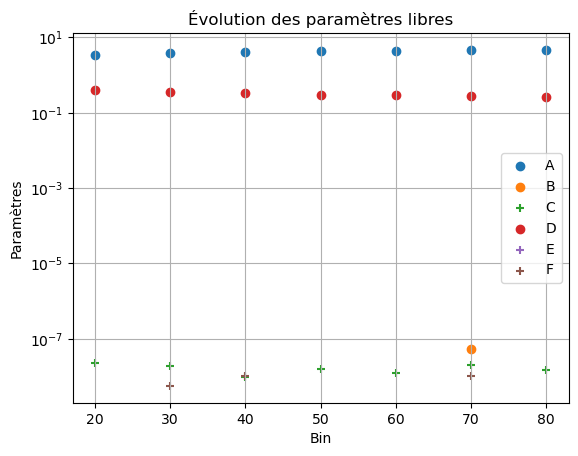

In [68]:
plt.clf()
list_bin = [20, 30, 40, 50, 60, 70, 80]
plt.scatter(list_bin, P[0], label = 'A', marker = 'o')
plt.scatter(list_bin, P[1], label = 'B', marker = 'o')
plt.scatter(list_bin, P[2], label = 'C', marker = '+')
plt.scatter(list_bin, P[3], label = 'D', marker = 'o')
plt.scatter(list_bin, P[4], label = 'E', marker = '+')
plt.scatter(list_bin, P[5], label = 'F', marker = '+')

plt.yscale('log')
plt.grid()
plt.xlabel("Bin")
plt.ylabel("Paramètres")
plt.title('Évolution des paramètres libres')
plt.legend()
plt.show()